<a href="https://colab.research.google.com/github/somilasthana/MachineLearningSkills/blob/master/Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
PCA is used to decompose a multivariate dataset in a set of orthogonal components 
that explain the maximum amount of variance.

PCA centers does not scale the input data for each feature before applying SVD
The optional parameter parameter whiten=True makes it possible to project the 
data onto the singular space while scaling each component to unit variance.

The biggest limitation is that PCA only supports batch processing, which means 
all of the data to be processed must fit in main memory.

It is often interesting to project data to a lower-dimensional space that 
preserves most of the variance, by dropping the singular vector of components 
associated with lower singular values.


if we work with 64x64 pixel gray-level pictures for face recognition, the 
dimensionality of the data is 4096 and it is slow to train an RBF support 
vector machine on such wide data. Furthermore we know that the intrinsic 
dimensionality of the data is much lower than 4096 since all pictures of 
human faces look somewhat alike. The samples lie on a manifold of much lower 
dimension (say around 200 for instance). The PCA algorithm can be used to 
linearly transform the data while both reducing the dimensionality and preserve 
most of the explained variance at the same time.

"""

In [0]:
"""PCA """

from time import time

import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from sklearn.decomposition import PCA
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data

n_features= X.shape[1]

y = lfw_people.target

target_names = lfw_people.target_names

n_classes = target_names.shape[0]


2019-06-07 11:50:59,174 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-06-07 11:51:00,264 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-06-07 11:51:01,207 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-06-07 11:51:02,315 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [3]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

Extracting the top 150 eigenfaces from 966 faces


In [0]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

In [0]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [0]:
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

In [9]:
#############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
param_grid={'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    param_grid,
    cv=5, iid=False
)

Fitting the classifier to the training set


In [0]:
clf = clf.fit(X_train_pca, y_train)

In [11]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
y_pred = clf.predict(X_test_pca)


In [13]:
print(classification_report(y_test, y_pred, target_names = target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.94      0.81      0.87        36

         accuracy                           0.86       322
        macro avg       0.90      0.74      0.79       322
     weighted avg       0.86      0.86      0.85       322



In [14]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  7   1   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  0   3  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   2   1   8   1]
 [  0   1   2   4   0   0  29]]


In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=0.1, right=0.99, top=0.9, hspace=0.35)
  
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(images[i].reshape((h, w)), cmap="gray")
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

In [0]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [0]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

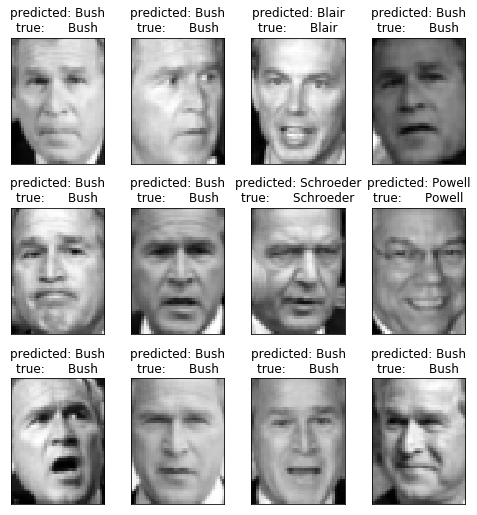

In [18]:
plot_gallery(X_test, prediction_titles, h, w)

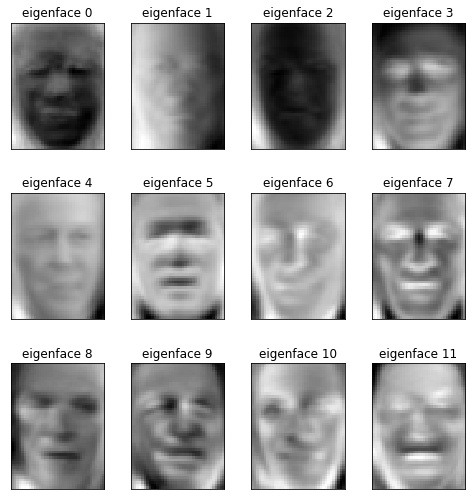

In [19]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)


In [0]:
"""
SparsePCA: 
Principal component analysis (PCA) has the disadvantage that the components 
extracted by this method have exclusively dense expressions, i.e. they have 
non-zero coefficients when expressed as linear combinations of the original 
variables. This can make interpretation difficult.

For PCA in face recognition, components might not naturally map to parts of faces.

Sparse principal components yields a more parsimonious, interpretable 
representation, clearly emphasizing which of the original features contribute 
to the differences between samples.

In SparsePCA regularization term induces many zeros. Furthermore, the natural 
structure of the data causes the non-zero coefficients to be vertically adjacent.

optimization problem solved is 
(U*, V*) = arg min 1/2 sqr(|| X - UV ||) + alpha * || V ||

"""

In [0]:
from sklearn.decomposition import MiniBatchSparsePCA


mbatch_pca = MiniBatchSparsePCA (
    n_components=n_components,
    alpha=0.9,
    n_iter=100,
    batch_size=3,
    random_state=42, 
    normalize_components=True
).fit(X_train)

In [0]:
eigen_faces_sparse = mbatch_pca.components_.reshape((n_components, h, w))

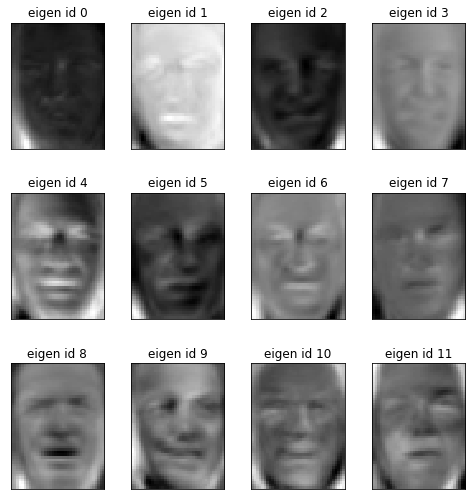

In [24]:
eigen_title_sparse = [ "eigen id %d"%i for i in range(eigen_faces_sparse.shape[0])]
plot_gallery(eigen_faces_sparse, eigen_title_sparse, h, w)

In [0]:
"""
TruncatedSVD implements a variant of singular value decomposition (SVD) that 
only computes the k largest singular values, where k is a user-specified parameter.

When TruncatedSVD is applied to term-document ( CountVectorizer, TfidfVectorizer )
then this transformation is known as Latent Semantic Analysis / Indexing

Mathematically, 

  X = X_k = U_k Sigma_k V.T_k
  
  U_k Sigma_k  is transformed X_k ie low rank matrix
  
  X_test can be tranformed as X_test V_k

TruncatedSVD is similar to PCA however, it works on sample matrices X directly 
instead of their covariate matrices

TruncatedSVD works best for TFIDF transformed data because feature values matches closer to 
Gaussian distribution.

"""

In [0]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from optparse import OptionParser
import numpy as np

In [0]:
op=OptionParser()
op.add_option("--lsa", dest="n_components", type="int", help="Preprocess using LSA")
op.add_option("--no-minibatch", action="store_false", dest="minibatch", default=True, help="Use ordinary k-means algorithm")
(opts, args) = op.parse_args(rgv)

print("Number of components %d" % op.n_components)

In [26]:
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

2019-06-07 11:55:41,846 Downloading 20news dataset. This may take a few minutes.
2019-06-07 11:55:41,848 Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


3387 documents
4 categories



In [0]:
hasher = HashingVectorizer(n_features=10000, stop_words='english', alternate_sign=False, norm=None, binary=False)
vectorizer = make_pipeline(hasher, TfidfTransformer())

In [0]:
X = vectorizer.fit_transform(dataset.data)

In [29]:
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 3387, n_features: 10000


In [0]:
svd = TruncatedSVD(3000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [31]:
print("n_samples: %d, n_features: %d" % X.shape)
explained_variance = svd.explained_variance_ratio_.sum()
print("explained ratio %d" % int(explained_variance * 100))

n_samples: 3387, n_features: 3000
explained ratio 99


In [0]:
km = MiniBatchKMeans(n_clusters=true_k, init="k-means++", n_init=1, init_size=1000, batch_size=1000, verbose=True)

In [33]:
km.fit(X)

Init 1/1 with method: k-means++
Inertia for init 1/1: 966.150275
Minibatch iteration 1/400: mean batch inertia: 0.970155, ewa inertia: 0.970155 
Minibatch iteration 2/400: mean batch inertia: 0.967192, ewa inertia: 0.968406 
Minibatch iteration 3/400: mean batch inertia: 0.965341, ewa inertia: 0.966597 
Minibatch iteration 4/400: mean batch inertia: 0.965179, ewa inertia: 0.965760 
Minibatch iteration 5/400: mean batch inertia: 0.963834, ewa inertia: 0.964623 
Minibatch iteration 6/400: mean batch inertia: 0.961357, ewa inertia: 0.962695 
Minibatch iteration 7/400: mean batch inertia: 0.962880, ewa inertia: 0.962804 
Minibatch iteration 8/400: mean batch inertia: 0.960902, ewa inertia: 0.961681 
Minibatch iteration 9/400: mean batch inertia: 0.961546, ewa inertia: 0.961602 
Minibatch iteration 10/400: mean batch inertia: 0.960097, ewa inertia: 0.960713 
Minibatch iteration 11/400: mean batch inertia: 0.960421, ewa inertia: 0.960541 
Minibatch iteration 12/400: mean batch inertia: 0.961

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)

In [34]:
print("Homogenity score %0.3f" % metrics.homogeneity_score(labels, km.labels_))

Homogenity score 0.408


In [35]:
print("Adjusted Rand-Index %0.3f" % metrics.adjusted_rand_score(labels, km.labels_))

Adjusted Rand-Index 0.334


In [36]:
print("Silhouette score %0.3f " % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Silhouette score 0.007 


In [0]:
"""
Factor Analysis
A simple Linear Generative Model with Gausssian latent variables

The observations are assumed to be caused by a linear transformation of lower
dimension latent factors and added Gaussian noise.
These factors are distributed with zero mean and unit covariance

Factor Analysis performs maximum likeihood estimate on loading matrix, the 
transformation of latent variables to an observed one using EM techniques

"""

In [37]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis

X, _ = load_digits(return_X_y=True)
print(X.shape)
transformer = FactorAnalysis(n_components=7, random_state=42)

X_fa = transformer.fit_transform(X)
print(X_fa.shape)

(1797, 64)
(1797, 7)
